# Used Packages

In [3]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# from utils.MovingAverager import *
from collections import defaultdict

from datetime import datetime

from sklearn.metrics import accuracy_score

In [128]:
titles = ['gyro', 'gravity', 'lin_acc', 'mag']

def plot_curve(data):
    # acc_data = data[:, 7:10]
    # lin_acc_data = data[:, 10:13]
    # gyro_data = data[:, 4:7]
    # mag_data = data[:, 13:16]
    X = np.arange(len(data))

    fig, axes = plt.subplots(4, 1, figsize=(12, 6))

    for i in range(4):
        for j in range(3):
            axes[i].plot(X, data[:, 4 + i * 3 + j])
        axes[i].get_xaxis().set_visible(False)
        axes[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [163]:
def split_traj(data, length=100, shift=1000):
    data_len = len(data)
    selection_idx = np.arange(length) + np.arange(int(data_len / (length + shift)))[:, None] * (length + shift)

    return data[selection_idx]

In [267]:
selection_idx = np.arange(100) + np.arange(int(15000 / (100 + 400)))[:, None] * (100 + 400)

In [270]:
len(syn_imu)

14098

In [271]:
selection_idx

array([[    0,     1,     2, ...,    97,    98,    99],
       [  500,   501,   502, ...,   597,   598,   599],
       [ 1000,  1001,  1002, ...,  1097,  1098,  1099],
       ...,
       [13500, 13501, 13502, ..., 13597, 13598, 13599],
       [14000, 14001, 14002, ..., 14097, 14098, 14099],
       [14500, 14501, 14502, ..., 14597, 14598, 14599]])

# Global Variable

In [113]:
# Time attitude_roll(radians) attitude_pitch(radians) attitude_yaw(radians) rotation_rate_x(radians/s) rotation_rate_y(radians/s) rotation_rate_z(radians/s) gravity_x(G) gravity_y(G) gravity_z(G) user_acc_x(G) user_acc_y(G) user_acc_z(G) magnetic_field_x(microteslas) magnetic_field_y(microteslas) magnetic_field_z(microteslas)
imu_header = ['time', 'attitude_roll', 'attitude_pitch', 'attitude_yaw', 'rotation_rate_x', 'rotation_rate_y', 'rotation_rate_z', 'gravity_x', 'gravity_y', 'gravity_z', 'user_acc_x', 'user_acc_y', 'user_acc_z', 'magnetic_field_x', 'magnetic_field_y', 'magnetic_field_z']
# Time  Header  translation.x translation.y translation.z rotation.x rotation.y rotation.z rotation.w
vi_header = ['time', 'translation.x', 'translation.y', 'translation.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']

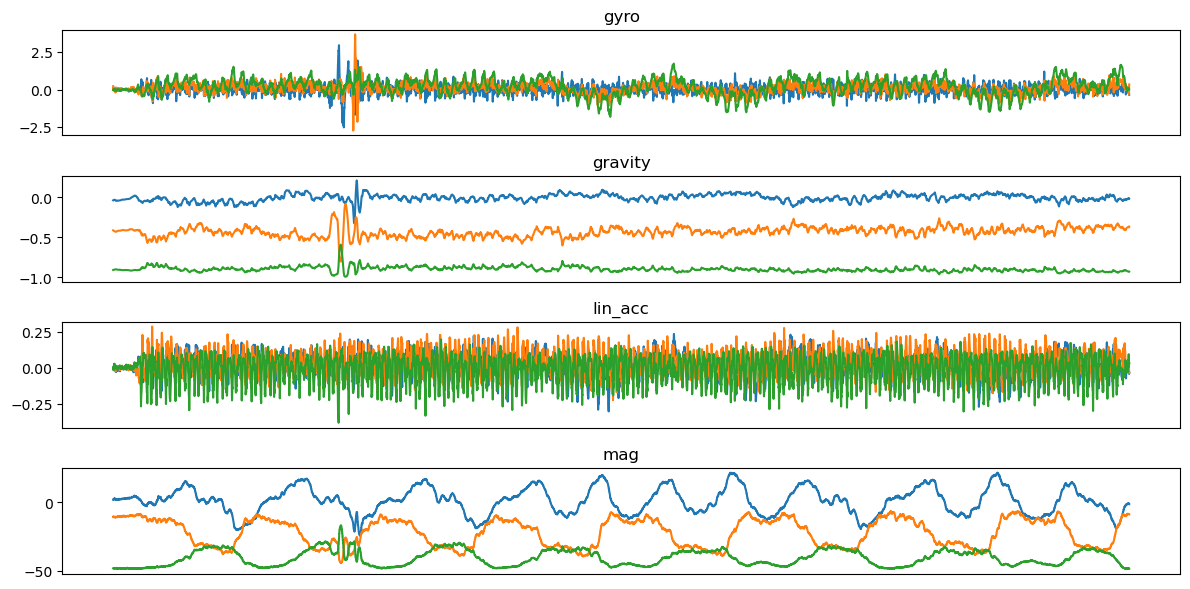

NameError: name 'qq' is not defined

In [215]:
# folders = set(glob.glob(r'./OxIOD/*')) - set(glob.glob(r'./OxIOD/*.*'))
folders = ['./OxIOD/handheld']
res = []

for folder in folders:
    # sub_folders = set(glob.glob(folder + '/*')) - set(glob.glob(folder + '/*.*'))
    sub_folders = [folder + '/data1']

    for sub_folder in sub_folders:
        num_of_files = int(len(os.listdir(sub_folder + '/raw')) / 2)

        # for i in range(1, num_of_files + 1):
        for i in [7]:
            raw_imu = pd.read_csv(sub_folder + f'/raw/imu{i}.csv', header=None, names=imu_header)
            raw_vi = pd.read_csv(sub_folder + f'/raw/vi{i}.csv', header=None, names=vi_header)

            syn_imu = pd.read_csv(sub_folder + f'/syn/imu{i}.csv', header=None, names=imu_header)
            syn_vi = pd.read_csv(sub_folder + f'/syn/vi{i}.csv', header=None, names=vi_header)

            plot_curve(raw_imu.values)
            res.extend(split_traj(syn_imu.values, 100, 150))
            qq

In [216]:
res = np.array(res)
res.shape

(56, 100, 16)

## 分類data

In [187]:
from sklearn import cluster
from dtaidistance import dtw_ndim

In [237]:
# acc_data = data[:, 7:10]
# lin_acc_data = data[:, 10:13]
# gyro_data = data[:, 4:7]
# mag_data = data[:, 13:16]

def similarity(d1, d2):
    # acc_norm = np.linalg.norm(d1[..., :3] - d2[..., :3])
    # lin_acc_norm = np.linalg.norm(d1[..., 3:6] - d2[..., 3:6])
    # gyro_norm = np.linalg.norm(d1[..., 6:9] - d2[..., 6:9])
    acc_norm = dtw_ndim.distance_fast(d1[..., 7:10], d2[..., 7:10], use_pruning=True)
    lin_acc_norm = dtw_ndim.distance_fast(d1[..., 10:13], d2[..., 10:13], use_pruning=True)
    gyro_norm = dtw_ndim.distance_fast(d1[..., 4:7], d2[..., 4:7], use_pruning=True)
    # print(acc_norm, lin_acc_norm, gyro_norm)
    return acc_norm * 0.5 + lin_acc_norm * 1.5 + gyro_norm * 0.15

In [238]:
data = res

In [239]:
similarity_matrix = np.zeros((len(data), len(data)))

for i in range(len(data)):
    for j in range(len(data)):
        similarity_matrix[i, j] = similarity(data[i], data[j])

In [240]:
np.mean(similarity_matrix)

3.7595987738310046

In [245]:
hclust = cluster.DBSCAN(eps=1.75, min_samples=2, metric='precomputed')
hclust.fit(similarity_matrix)

DBSCAN(eps=1.75, metric='precomputed', min_samples=2)

In [246]:
hclust.labels_

array([ 0,  0, -1,  1,  2, -1, -1,  3, -1, -1, -1,  2, -1, -1, -1,  4,  5,
       -1, -1,  2,  1, -1, -1,  5, -1, -1, -1, -1, -1, -1,  2, -1,  6, -1,
       -1, -1, -1, -1, -1,  3,  4, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1,
        6, -1, -1, -1, -1])

In [221]:
hclust.labels_

array([ 0,  0, -1,  1,  2, -1, -1,  3, -1, -1, -1,  4, -1, -1, -1,  5,  6,
       -1,  7,  4,  1, -1, -1,  6, -1, -1, -1, -1, -1,  7,  2, -1,  8,  8,
       -1, -1, -1,  2, -1,  3,  5, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1,
       -1, -1, -1, -1, -1])

In [266]:
np.where(hclust.labels_ == 3), np.where(hclust.labels_ == 3)[0] * 500

((array([ 7, 39, 46]),), array([ 3500, 19500, 23000]))

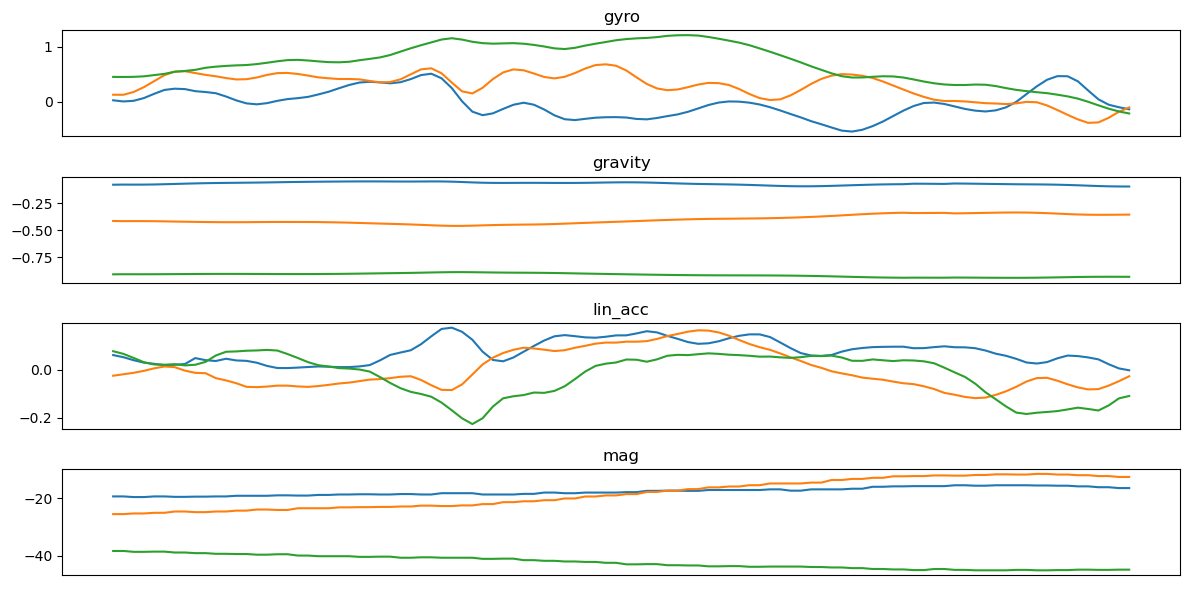

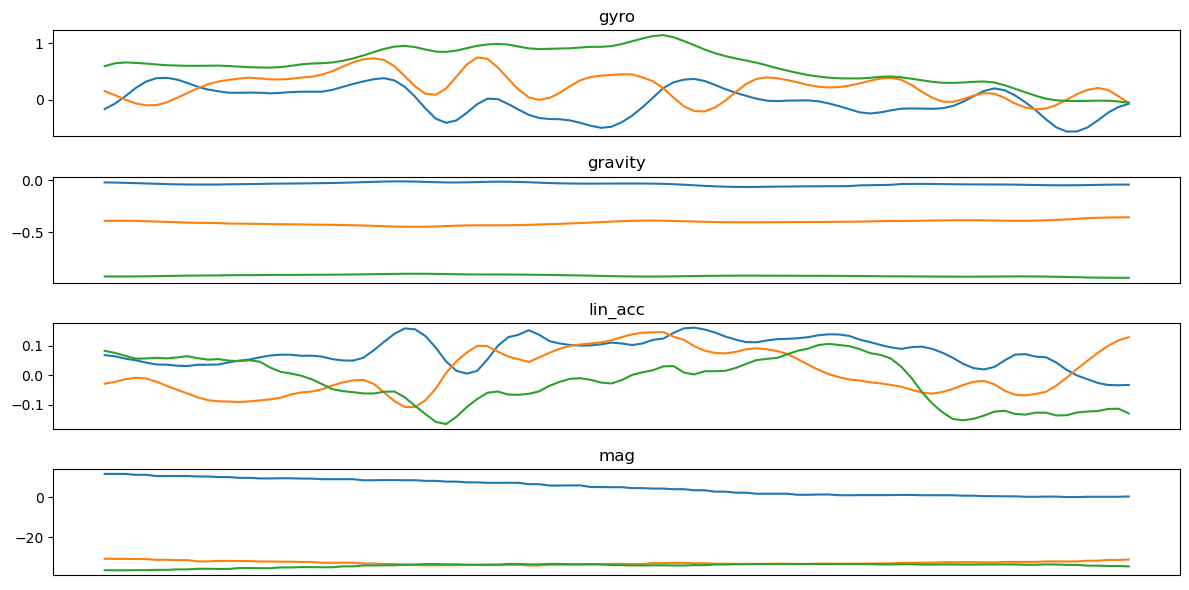

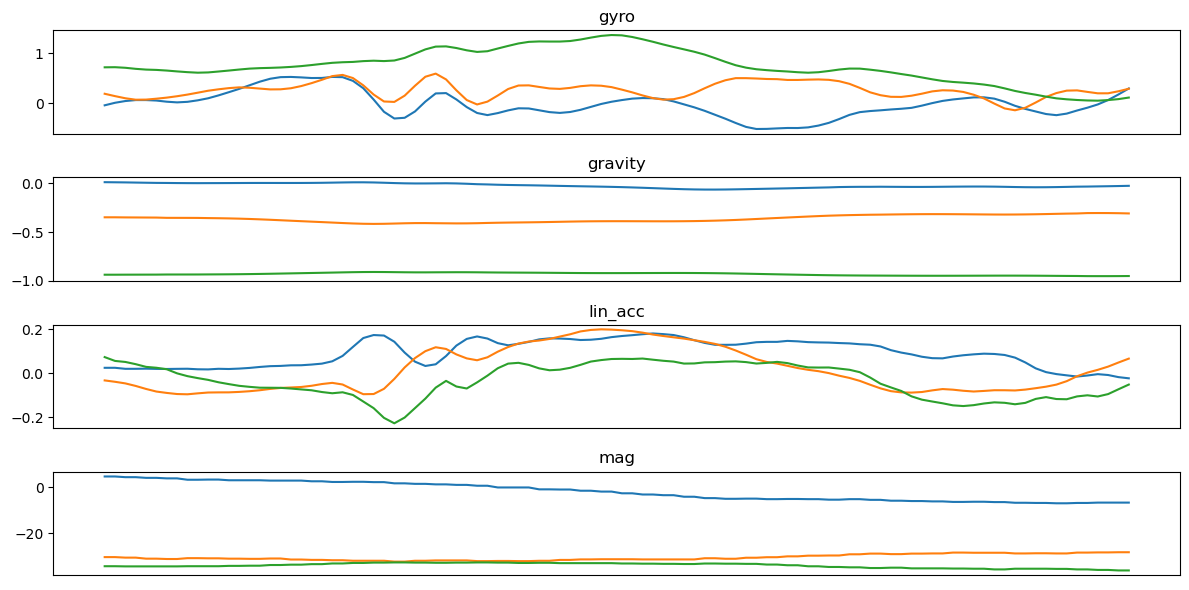

In [260]:
for idx in np.where(hclust.labels_ == 3)[0]:
    sdata = res[idx]
    plot_curve(sdata)